In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

Let’s load the train and test data and find out the insights

In [ ]:
# loading data set from excel file
nps_data = pd.read_excel('/content/drive/MyDrive/NPS_responses.xlsx')

In [ ]:
nps_data.head()

,Survey_Time,Time_taken_respond,Survey_finished_mobile,Comment,Invitation_Flag,Account_Type,Contract_Type,Claim_Amount,Claim_Status,Class_label
0,0.766667,25.388114,Yes,Prompt sevice,Email,General Agent,FUTURE SECURE PRIVATE CAR,117136.0,Settled,Promoter
1,0.833333,9.386237,Yes,Good experience,Email,Broker,Future Secure Private Car,14783.0,Settled,Promoter
2,2.983333,6.191316,Yes,Although the response of my text message for c...,Email,General Agent,Future Secure Private Car,NaN,Withdrawn,Promoter
3,3.216667,25.076517,Yes,Very supportive and fast work process for my c...,Email,Broker,MISP SECURE PRIVATE CAR,45488.0,Settled,Promoter
4,NaN,12.906843,Yes,In Jharkhand you don't provide cashless featur...,SMS,Point of Sale,Future Secure Two Wheeler,4100.0,Settled,Detractor


In [ ]:
shape = nps_data.shape
print('Number of Feedbacks : ',shape[0])
print('Number of Features : ',(shape[1]-1))

Number of Feedbacks :  5871
Number of Features :  9


In [ ]:
print('Features :',nps_data.columns)

Features : Index(['Survey_Time', 'Time_taken_respond', 'Survey_finished_mobile',
       'Comment', 'Invitation_Flag', 'Account_Type', 'Contract_Type',
       'Claim_Amount', 'Claim_Status', 'Class_label'],
      dtype='object')


It is necessary to remove duplicates in order to get unbiased results for the analysis of the data. Lets check if any duplicate entries are there and remove them.

In [ ]:
#Deduplication of entries
final_nps_data = nps_data .drop_duplicates(subset={"Comment","Invitation_Flag","Claim_Amount","Claim_Status","Account_Type","Contract_Type"}, keep='first', inplace=False)
final_nps_data.shape

(5871, 10)

###Statistics of Dataset :

In [ ]:
final_nps_data.describe()

,Survey_Time,Time_taken_respond,Claim_Amount
count,5428.000000,5871.000000,5.701000e+03
mean,4.302450,6.181082,4.153911e+04
std,7.226534,6.477481,1.277227e+05
min,0.366667,0.001470,5.740000e+02
25%,1.433333,1.074048,8.012000e+03
50%,2.483333,4.267758,1.525100e+04
75%,4.316667,8.255684,3.027200e+04
max,86.266667,29.947195,5.452706e+06


In [ ]:
final_nps_data.describe(include = 'object')

,Survey_finished_mobile,Comment,Invitation_Flag,Account_Type,Contract_Type,Claim_Status,Class_label
count,5871,5871,5871,5871,5871,5869,5871
unique,2,4012,2,11,38,7,3
top,Yes,Good service,Email,Broker,FUTURE SECURE PRIVATE CAR,Settled,Promoter
freq,4356,391,5027,2448,2073,5663,5141


In [ ]:
cont_features = list(final_nps_data.select_dtypes(include=['float64', 'int64']).columns)
print ("Continuous features: {} features".format(len(cont_features)))

cat_features = [cont for cont in list(final_nps_data.select_dtypes(
                 include=['object']).columns) if cont not in ['Class_label']]
print ("Categorical features: {} features".format(len(cat_features)))

Continuous features: 3 features
Categorical features: 6 features


###Testing on missing values
We should always dedicate a part of our research on dealing with missing values.Pandas provides an easy way to detect them.

In [ ]:
final_nps_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5871 entries, 0 to 5870
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Survey_Time             5428 non-null   float64
 1   Time_taken_respond      5871 non-null   float64
 2   Survey_finished_mobile  5871 non-null   object 
 3   Comment                 5871 non-null   object 
 4   Invitation_Flag         5871 non-null   object 
 5   Account_Type            5871 non-null   object 
 6   Contract_Type           5871 non-null   object 
 7   Claim_Amount            5701 non-null   float64
 8   Claim_Status            5869 non-null   object 
 9   Class_label             5871 non-null   object 
dtypes: float64(3), object(7)
memory usage: 504.5+ KB


Here we can see that Survey_Time,Claim_Amount,Claim_Status features have some null values are Non-Null Count is less than number of rows.

Let's cross check if there are missing values in dataset.

In [ ]:
pd.isnull(final_nps_data).values.any()

True

Filling numerical features with mean value and categorical features with most frequent value.

In [ ]:
final_nps_data['Survey_Time'] = final_nps_data['Survey_Time'].fillna(final_nps_data['Survey_Time'].mean())
final_nps_data['Claim_Amount'] = final_nps_data['Claim_Amount'].fillna(final_nps_data['Claim_Amount'].mean())
final_nps_data['Claim_Status'] = final_nps_data['Claim_Status'].fillna(final_nps_data['Claim_Status'].mode().iloc[0])

In [ ]:
final_nps_data.head()

,Survey_Time,Time_taken_respond,Survey_finished_mobile,Comment,Invitation_Flag,Account_Type,Contract_Type,Claim_Amount,Claim_Status,Class_label
0,0.766667,25.388114,Yes,Prompt sevice,Email,General Agent,FUTURE SECURE PRIVATE CAR,117136.000000,Settled,Promoter
1,0.833333,9.386237,Yes,Good experience,Email,Broker,Future Secure Private Car,14783.000000,Settled,Promoter
2,2.983333,6.191316,Yes,Although the response of my text message for c...,Email,General Agent,Future Secure Private Car,41539.111559,Withdrawn,Promoter
3,3.216667,25.076517,Yes,Very supportive and fast work process for my c...,Email,Broker,MISP SECURE PRIVATE CAR,45488.000000,Settled,Promoter
4,4.302450,12.906843,Yes,In Jharkhand you don't provide cashless featur...,SMS,Point of Sale,Future Secure Two Wheeler,4100.000000,Settled,Detractor


In [ ]:
pd.isnull(final_nps_data).values.any()

False

In [ ]:
final_nps_data['Class_label'].replace(to_replace ="Promoter",
                 value = 1,inplace = True)
final_nps_data['Class_label'].replace(to_replace ='Detractor',
                 value = 0,inplace = True)
final_nps_data['Class_label'].replace(to_replace ="Passive",
                 value = 0,inplace = True)

In [ ]:
final_nps_data.head()

,Survey_Time,Time_taken_respond,Survey_finished_mobile,Comment,Invitation_Flag,Account_Type,Contract_Type,Claim_Amount,Claim_Status,Class_label
0,0.766667,25.388114,Yes,Prompt sevice,Email,General Agent,FUTURE SECURE PRIVATE CAR,117136.000000,Settled,1
1,0.833333,9.386237,Yes,Good experience,Email,Broker,Future Secure Private Car,14783.000000,Settled,1
2,2.983333,6.191316,Yes,Although the response of my text message for c...,Email,General Agent,Future Secure Private Car,41539.111559,Withdrawn,1
3,3.216667,25.076517,Yes,Very supportive and fast work process for my c...,Email,Broker,MISP SECURE PRIVATE CAR,45488.000000,Settled,1
4,4.302450,12.906843,Yes,In Jharkhand you don't provide cashless featur...,SMS,Point of Sale,Future Secure Two Wheeler,4100.000000,Settled,0


#Data analysis: 

Let's check count of promoter and detractor in dataset.

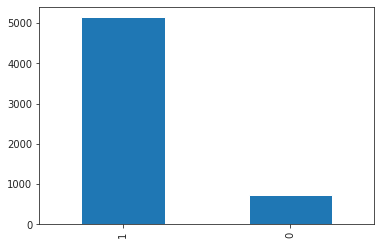

In [ ]:
final_nps_data['Class_label'].value_counts().plot(kind='bar')

Here we can see data is imbalanced as class 1 is majority class.

Let's start analysis with comments.

In [ ]:
# Python program to generate WordCloud
# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

def word_cloud(nps_data):
  comment_words = ''
  for val in nps_data.Comment:    
    # typecaste each val to string
    val = str(val)
    # split the value
    tokens = val.split() 
    comment_words += " ".join(tokens)+" "
  wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
 
  plt.show()

In [ ]:
nps_data_pos = final_nps_data[final_nps_data['Class_label'] == 1]
nps_data_neg = final_nps_data[final_nps_data['Class_label'] == 0]

Words are common in positive feedbacks.

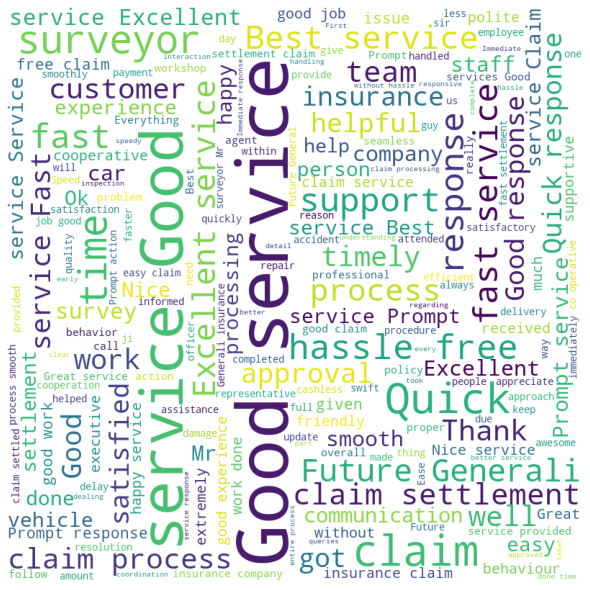

In [ ]:
word_cloud(nps_data_pos)

Words are common in negative feedbacks.

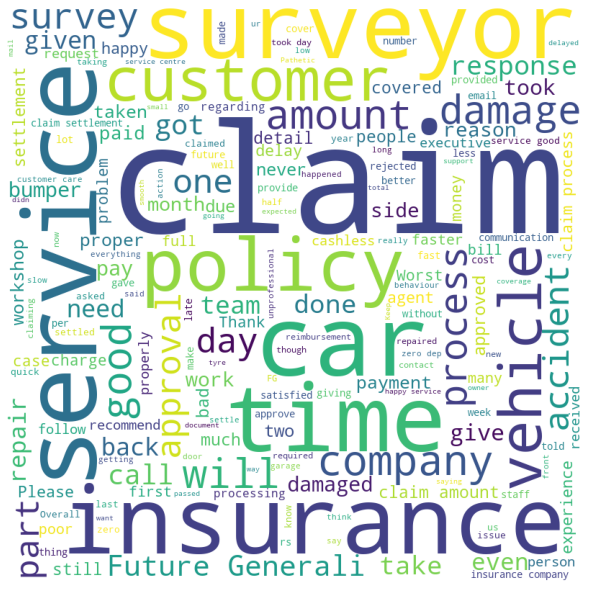

In [ ]:
word_cloud(nps_data_neg)

Analysis for time taken to complete survey.

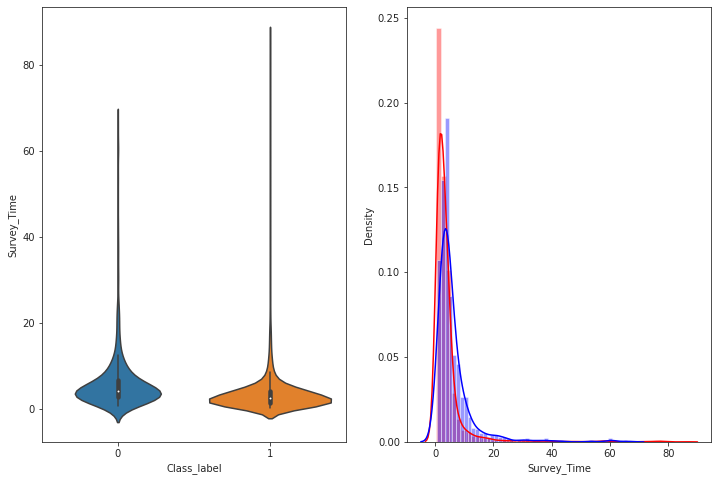

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'Class_label', y = 'Survey_Time', data = final_nps_data[0:])

plt.subplot(1,2,2)
sns.distplot(final_nps_data[final_nps_data['Class_label'] == 1.0]['Survey_Time'][0:] , label = "1", color = 'red')
sns.distplot(final_nps_data[final_nps_data['Class_label'] == 0.0]['Survey_Time'][0:] , label = "0" , color = 'blue' )
plt.show()

*  After plotting time taken by customer to submit survey , pdfs are almost overlapping.
*  While customer giving positive feedback taking less time as compared with customer giving negative feedback.



Analysis of customer take time to respond to survey.

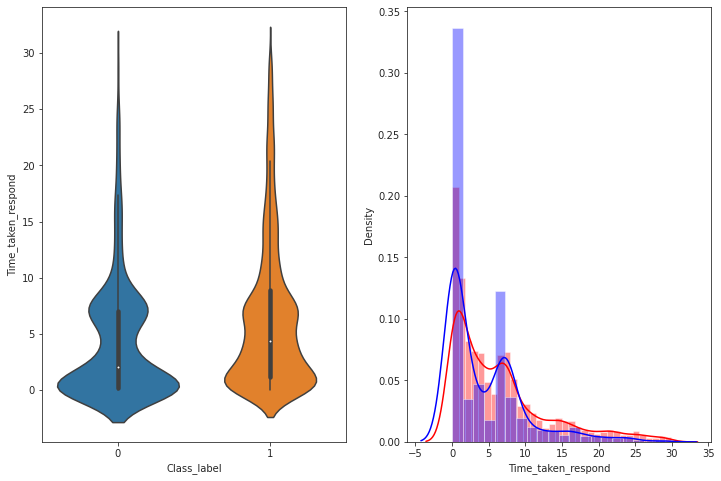

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'Class_label', y = 'Time_taken_respond', data = final_nps_data[0:])

plt.subplot(1,2,2)
sns.distplot(final_nps_data[final_nps_data['Class_label'] == 1.0]['Time_taken_respond'][0:] , label = "Promoter", color = 'red')
sns.distplot(final_nps_data[final_nps_data['Class_label'] == 0.0]['Time_taken_respond'][0:] , label = "Detractor" , color = 'blue')
plt.show()

*  After plotting time taken by customer to respond to survey , pdfs are almost overlapping and cannot differentiate easily.
*  Customer giving negative feedback are respond faster than customer giving positive feedback.

Anlysis of claim amount settled.

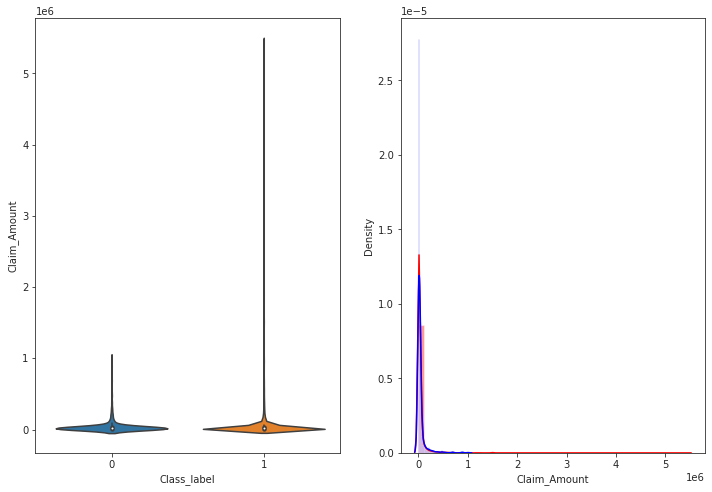

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'Class_label', y = 'Claim_Amount', data = final_nps_data[0:])

plt.subplot(1,2,2)
sns.distplot(final_nps_data[final_nps_data['Class_label'] == 1.0]['Claim_Amount'][0:] , label = "1", color = 'red')
sns.distplot(final_nps_data[final_nps_data['Class_label'] == 0.0]['Claim_Amount'][0:] , label = "0" , color = 'blue' )
plt.show()

Here we can see that there might be chance of outliers that is sudden surge of claim amount.

Let's check with boxplot.

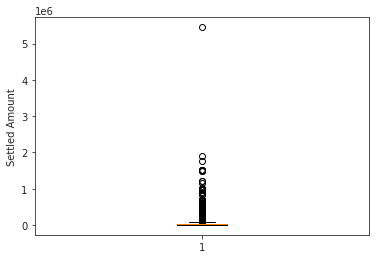

In [ ]:
plt.boxplot(final_nps_data['Claim_Amount'])
plt.ylabel('Settled Amount')
plt.show()

Here we can see there extreme amounts settled amount may be due to major loss claims whoose frequency is less.

Let's check with percentile values.


In [ ]:
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(final_nps_data['Claim_Amount'],90+i))

90 percentile value is 71264.0
91 percentile value is 79603.0
92 percentile value is 90157.20000000001
93 percentile value is 104353.4000000001
94 percentile value is 121310.59999999983
95 percentile value is 147797.5
96 percentile value is 176228.19999999978
97 percentile value is 233990.99999999945
98 percentile value is 322310.5999999986
99 percentile value is 508709.6000000004
100 percentile value is 5452706.0


In [ ]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(final_nps_data['Claim_Amount'],99+(i/100)))

99.1 percentile value is 537220.340000001
99.2 percentile value is 559174.7199999997
99.3 percentile value is 597751.3299999996
99.4 percentile value is 643577.1800000173
99.5 percentile value is 697966.5499999989
99.6 percentile value is 888787.0
99.7 percentile value is 957117.5000000059
99.8 percentile value is 1045479.9400000328
99.9 percentile value is 1502461.9000000018
100.0 percentile value is 5452706.0


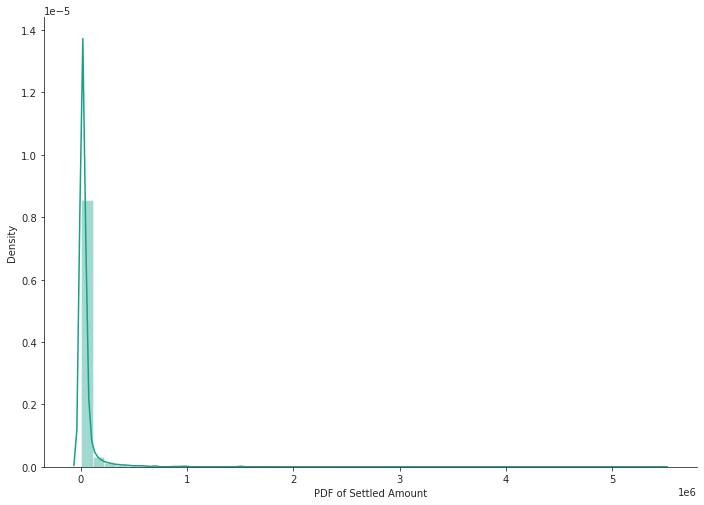

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(final_nps_data['Claim_Amount'], color='#16A085')
plt.xlabel('PDF of Settled Amount')
sns.despine()